# Time processing for every ONNX nodes in a graph

The following notebook show how long the runtime spends in each node of an ONNX graph.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%load_ext mlprodict

The mlprodict extension is already loaded. To reload it, use:
  %reload_ext mlprodict


## LogisticRegression

In [3]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
iris = load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y)
clr = LogisticRegression(solver='liblinear')
clr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [4]:
import numpy
from mlprodict.onnxrt import to_onnx
onx = to_onnx(clr, X_test.astype(numpy.float32))
# add -l 1 if nothing shows up
%onnxview onx

The maximum opset needed by this model is only 9.
The maximum opset needed by this model is only 1.


In [5]:
from mlprodict.onnxrt import OnnxInference
import pandas
oinf = OnnxInference(onx)
res = oinf.run({'X': X_test}, node_time=True)
pandas.DataFrame(list(res[1]))

,i,name,op_type,time
0,0,LinearClassifier,LinearClassifier,0.000117
1,1,Normalizer,Normalizer,0.000040
2,2,Cast,Cast,0.000018
3,3,ZipMap,ZipMap,0.000020


In [6]:
oinf.run({'X': X_test})['output_probability'][:5]

{0: array([3.25402956e-02, 7.83945376e-01, 4.46566246e-02, 1.41617460e-03,
        3.66183914e-04]),
 1: array([0.8057367 , 0.21596894, 0.8415208 , 0.18757329, 0.39231561]),
 2: array([1.61723001e-01, 8.56878869e-05, 1.13822575e-01, 8.11010537e-01,
        6.07318208e-01])}

## Measure time spent in each node


With parameter ``node_time=True``, method *run* returns the output and time measurement.

In [7]:
exe = oinf.run({'X': X_test}, node_time=True)
exe[1]

[{'i': 0,
  'name': 'LinearClassifier',
  'op_type': 'LinearClassifier',
  'time': 0.00019039999999392876},
 {'i': 1,
  'name': 'Normalizer',
  'op_type': 'Normalizer',
  'time': 4.2199999995773396e-05},
 {'i': 2, 'name': 'Cast', 'op_type': 'Cast', 'time': 1.1499999999387e-05},
 {'i': 3,
  'name': 'ZipMap',
  'op_type': 'ZipMap',
  'time': 8.899999997424857e-06}]

In [8]:
import pandas
pandas.DataFrame(exe[1])

,i,name,op_type,time
0,0,LinearClassifier,LinearClassifier,0.000190
1,1,Normalizer,Normalizer,0.000042
2,2,Cast,Cast,0.000011
3,3,ZipMap,ZipMap,0.000009


## Logistic regression: python runtime vs onnxruntime

Function [enumerate_validated_operator_opsets](http://www.xavierdupre.fr/app/mlprodict/helpsphinx/mlprodict/onnxrt/validate/validate.html?highlight=enumerate_validated_operator_opsets#mlprodict.onnxrt.validate.validate.enumerate_validated_operator_opsets) implements automated tests for every model with artificial data. Option ``node_time`` automatically returns the time spent in each node and does it multiple time.

In [9]:
from mlprodict.onnxrt.validate import enumerate_validated_operator_opsets
res = list(enumerate_validated_operator_opsets(
            verbose=0, models={"LogisticRegression"}, opset_min=11,
            runtime='python', debug=False, node_time=True,
            filter_exp=lambda m, p: p == "b-cl"))

The maximum opset needed by this model is only 9.
The maximum opset needed by this model is only 1.
The maximum opset needed by this model is only 9.
The maximum opset needed by this model is only 1.


In [10]:
import pandas
df = pandas.DataFrame(res[0]['bench-batch'])
df['step'] = df.apply(lambda row: '{}-{}'.format(row['i'], row["name"]), axis=1)
df

,i,name,op_type,time,N,max_time,min_time,repeat,number,step
0,0,LinearClassifier,LinearClassifier,0.000027,1,0.000039,0.000018,20,30,0-LinearClassifier
1,1,Normalizer,Normalizer,0.000024,1,0.000034,0.000016,20,30,1-Normalizer
2,2,Cast,Cast,0.000007,1,0.000010,0.000005,20,30,2-Cast
3,3,ZipMap,ZipMap,0.000006,1,0.000009,0.000004,20,30,3-ZipMap
4,0,LinearClassifier,LinearClassifier,0.000033,10,0.000044,0.000018,20,20,0-LinearClassifier
5,1,Normalizer,Normalizer,0.000027,10,0.000036,0.000015,20,20,1-Normalizer
6,2,Cast,Cast,0.000008,10,0.000011,0.000004,20,20,2-Cast
7,3,ZipMap,ZipMap,0.000006,10,0.000010,0.000004,20,20,3-ZipMap
8,0,LinearClassifier,LinearClassifier,0.000037,100,0.000038,0.000029,5,8,0-LinearClassifier
9,1,Normalizer,Normalizer,0.000031,100,0.000034,0.000027,5,8,1-Normalizer


Following tables shows the time spent in each node, it is relative to the total time. For one observation, the runtime spends 10% of the time in ZipMap, it is only 1% or 2% with 10 observations. These proportions change due to the computing cost of each node.

In [11]:
piv = df.pivot('step', 'N', 'time')
total = piv.sum(axis=0)
piv / total

N,1,10,100,1000,10000,100000
step,,,,,,
0-LinearClassifier,0.419224,0.446071,0.456254,0.491583,0.508307,0.587334
1-Normalizer,0.373720,0.364154,0.384118,0.426533,0.470673,0.401430
2-Cast,0.110741,0.102497,0.084923,0.047826,0.014393,0.010125
3-ZipMap,0.096315,0.087279,0.074706,0.034058,0.006627,0.001111


The python implementation of *ZipMap* does not change the data but wraps in into a frozen class [ArrayZipMapDitionary](https://github.com/sdpython/mlprodict/blob/master/mlprodict/onnxrt/ops_cpu/op_zipmap.py#L90) which mocks a list of dictionaries *pandas* can ingest to create a DataFrame. The cost is a fixed cost and does not depend on the number of processed rows.

In [12]:
from pyquickhelper.pycode.profiling import profile
bigX = numpy.random.randn(100000, X_test.shape[1]).astype(numpy.float32)
df = profile(lambda: oinf.run({'X': bigX}), as_df=True)[1]
df['file'] = df['file'].apply(lambda s: s.split("GitHub")[-1])
df

,namefct,file,ncalls1,ncalls2,tin,cum_tin,tall,cum_tall
0,onnx_inference.py:312-run,\mlprodict\mlprodict\onnxrt\onnx_inference.py:312,2,2,3.430000e-05,4.080000e-05,3.307310e-02,4.961290e-02
1,370-_run_sequence_runtime,\mlprodict\mlprodict\onnxrt\onnx_inference.py:370,7,7,1.018000e-04,1.296000e-04,3.303880e-02,4.957210e-02
2,onnx_inference_node.py:109-run,\mlprodict\mlprodict\onnxrt\onnx_inference_nod...,24,24,1.022000e-04,1.744000e-04,3.293520e-02,4.943890e-02
3,_op.py:169-run,\mlprodict\mlprodict\onnxrt\ops_cpu\_op.py:169,4,4,5.379900e-03,5.386200e-03,3.186550e-02,4.780140e-02
4,<ipython-input-17-d4f3af6cfacf>:3-<lambda>,<ipython-input-17-d4f3af6cfacf>:3,2,2,1.110000e-05,1.110000e-05,3.308420e-02,3.308420e-02
5,_op.py:282-run,\mlprodict\mlprodict\onnxrt\ops_cpu\_op.py:282,2,2,9.900000e-06,1.670000e-05,2.103700e-02,3.155890e-02
6,op_linear_classifier.py:38-_run,\mlprodict\mlprodict\onnxrt\ops_cpu\op_linear_...,3,3,5.377900e-03,1.074480e-02,1.565710e-02,2.616910e-02
7,_op.py:249-run,\mlprodict\mlprodict\onnxrt\ops_cpu\_op.py:249,2,2,8.800000e-06,1.440000e-05,1.084720e-02,1.627360e-02
8,op_normalizer.py:61-_run,\mlprodict\mlprodict\onnxrt\ops_cpu\op_normali...,3,3,3.326200e-03,3.332900e-03,1.082850e-02,1.624610e-02
9,0-<built-in method numpy.core._multiarray_umat...,~:0,3,3,1.111600e-03,2.217400e-03,9.142600e-03,1.426680e-02


In [13]:
%matplotlib inline

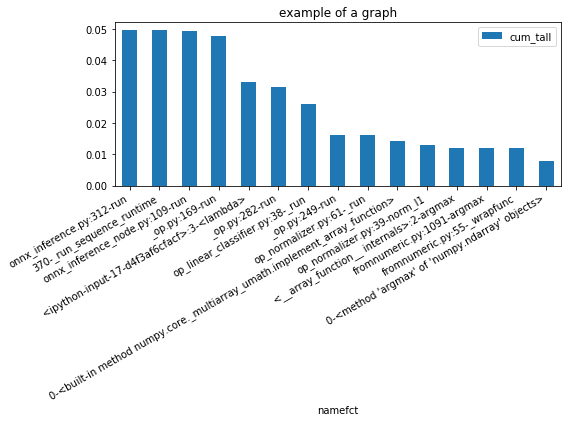

In [14]:
ax = df[['namefct', 'cum_tall']].head(n=15).set_index('namefct').plot(kind='bar', figsize=(8, 3), rot=30)
ax.set_title("example of a graph")
for la in ax.get_xticklabels():
    la.set_horizontalalignment('right');

The class *ArrayZipMapDictionary* is fast to build but has an overhead after that because it builds data when needed.

In [15]:
res = oinf.run({'X': bigX})
prob = res['output_probability']
type(prob)

mlprodict.onnxrt.ops_cpu.op_zipmap.ArrayZipMapDictionary

In [16]:
%timeit pandas.DataFrame(prob)

1.1 s ± 77.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
list_of_dict = [v.asdict() for v in prob]
%timeit pandas.DataFrame(list_of_dict)

203 ms ± 10.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


But if you just need to do the following:

In [18]:
%timeit pandas.DataFrame(prob).values

1.2 s ± 23.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Then, you can just do that:

In [19]:
print(prob.columns)
%timeit prob.values

[0, 1, 2]
289 ns ± 46.5 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


And then:


In [20]:
%timeit pandas.DataFrame(prob.values, columns=prob.columns)

312 µs ± 10.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


We can then compare to what *onnxruntime* would do when the runtime is called indenpently for each node. We use the runtime named [onnxruntime2](http://www.xavierdupre.fr/app/mlprodict/helpsphinx/onnx_runtime.html?highlight=onnxruntime2#onnxruntime2-independent-onnxruntime-for-every-node). Class *OnnxInference* splits the ONNX graph into multiple ONNX graphs, one for each node, and then calls *onnxruntime* for each of them indenpently. *Python* handles the graph logic.

In [21]:
res = list(enumerate_validated_operator_opsets(
            verbose=0, models={"LogisticRegression"}, opset_min=11,
            runtime='onnxruntime2', debug=False, node_time=True))
df = pandas.DataFrame(res[0]['bench-batch'])
df['step'] = df.apply(lambda row: '{}-{}'.format(row['i'], row["name"]), axis=1)
piv = df.pivot('step', 'N', 'time')
total = piv.sum(axis=0)
piv / total

The maximum opset needed by this model is only 9.
The maximum opset needed by this model is only 1.
The maximum opset needed by this model is only 9.
The maximum opset needed by this model is only 1.
The maximum opset needed by this model is only 9.
The maximum opset needed by this model is only 1.
The maximum opset needed by this model is only 9.
The maximum opset needed by this model is only 1.
The maximum opset needed by this model is only 9.
The maximum opset needed by this model is only 1.
The maximum opset needed by this model is only 9.
The maximum opset needed by this model is only 1.


N,1,10,100,1000,10000,100000
step,,,,,,
0-LinearClassifier,0.292141,0.310103,0.230527,0.144771,0.111862,0.090328
1-Normalizer,0.249276,0.268058,0.155501,0.061420,0.036962,0.033441
2-Cast,0.228336,0.196579,0.130200,0.028579,0.005246,0.007250
3-ZipMap,0.230246,0.225259,0.483772,0.765230,0.845931,0.868982


*onnxruntime* creates a new container each time a ZipMap is executed. That's whay it takes that much time and the ratio increases when the number of observations increases.

## GaussianProcessRegressor

This operator is slow for small batches compare to *scikit-learn* but closes the gap as the batch size increases. Let's see where the time goes.

In [22]:
res = list(enumerate_validated_operator_opsets(
            verbose=0, models={"GaussianProcessRegressor"}, opset_min=11,
            runtime='python', debug=False, node_time=True,
            filter_exp=lambda m, p: p == "b-reg"))

In [23]:
df = pandas.DataFrame(res[0]['bench-batch'])
df['step'] = df.apply(lambda row: '{0:02d}-{1}'.format(row['i'], row["name"]), axis=1)
df.head()

,i,name,op_type,time,N,max_time,min_time,repeat,number,step
0,0,Sc_Scan,Scan,0.008937,1,0.014180,0.006992,20,30,00-Sc_Scan
1,1,kgpd_Transpose,Transpose,0.000021,1,0.000037,0.000015,20,30,01-kgpd_Transpose
2,2,kgpd_Sqrt,Sqrt,0.000018,1,0.000027,0.000013,20,30,02-kgpd_Sqrt
3,3,kgpd_Div,Div,0.000019,1,0.000029,0.000014,20,30,03-kgpd_Div
4,4,kgpd_Mul,Mul,0.000014,1,0.000021,0.000011,20,30,04-kgpd_Mul


In [24]:
pivpy = df.pivot('step', 'N', 'time')
total = pivpy.sum(axis=0)
pivpy / total

N,1,10,100,1000,10000,100000
step,,,,,,
00-Sc_Scan,0.975468,0.963133,0.894245,0.623518,0.446108,0.562801
01-kgpd_Transpose,0.002313,0.002230,0.002326,0.001098,0.000229,0.000018
02-kgpd_Sqrt,0.001976,0.002167,0.002707,0.003483,0.004278,0.003072
03-kgpd_Div,0.002103,0.002655,0.003025,0.003652,0.005179,0.003293
04-kgpd_Mul,0.001581,0.001878,0.001797,0.002528,0.003892,0.002915
05-kgpd_Sin,0.001880,0.005640,0.026013,0.108384,0.147563,0.116780
06-kgpd_Div1,0.001415,0.001830,0.002164,0.004313,0.005133,0.004073
07-kgpd_Pow,0.002224,0.006878,0.038634,0.170953,0.287827,0.204663
08-kgpd_Mul1,0.001455,0.001860,0.002827,0.004060,0.004199,0.003323


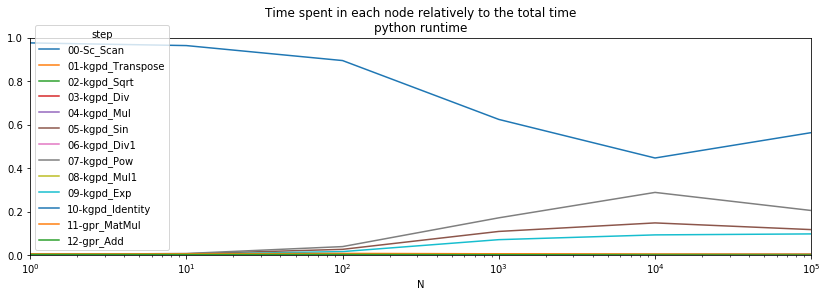

In [25]:
ax = (pivpy / total).T.plot(logx=True, figsize=(14, 4))
ax.set_ylim([0,1])
ax.set_title("Time spent in each node relatively to the total time\npython runtime");

The operator *Scan* is clearly time consuming when the batch size is small. *onnxruntime* is more efficient for this one.

In [26]:
res = list(enumerate_validated_operator_opsets(
            verbose=0, models={"GaussianProcessRegressor"}, opset_min=11,
            runtime='onnxruntime2', debug=False, node_time=True,
            filter_exp=lambda m, p: p == "b-reg"))

In [27]:
try:
    df = pandas.DataFrame(res[0]['bench-batch'])
except KeyError as e:
    raise RuntimeError("No model available in\n{}".format(df)) from e
df['step'] = df.apply(lambda row: '{0:02d}-{1}'.format(row['i'], row["name"]), axis=1)
pivort = df.pivot('step', 'N', 'time')
total = pivort.sum(axis=0)
pivort / total

N,1,10,100,1000,10000,100000
step,,,,,,
00-Sc_Scan,0.745670,0.739971,0.646162,0.430167,0.305360,0.344948
01-kgpd_Transpose,0.027003,0.030151,0.060543,0.115216,0.099167,0.087057
02-kgpd_Sqrt,0.018936,0.017829,0.017599,0.032843,0.047182,0.040560
03-kgpd_Div,0.021221,0.020490,0.017667,0.029955,0.045548,0.040881
04-kgpd_Mul,0.021121,0.019806,0.018445,0.030844,0.046407,0.052580
05-kgpd_Sin,0.019126,0.031516,0.102299,0.159994,0.162898,0.156548
06-kgpd_Div1,0.020905,0.019745,0.016854,0.029900,0.044944,0.056991
07-kgpd_Pow,0.021392,0.020400,0.016264,0.029486,0.043034,0.037279
08-kgpd_Mul1,0.022747,0.020123,0.016602,0.029015,0.044326,0.040826


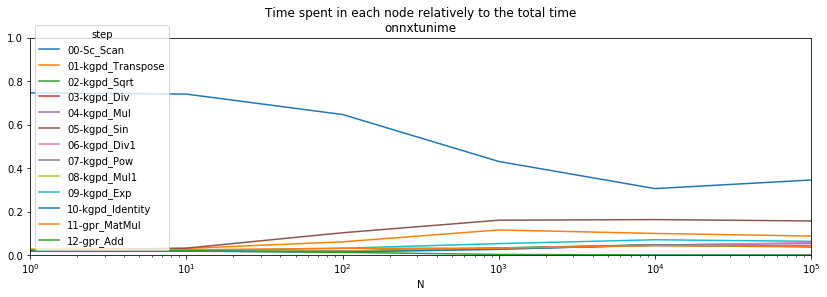

In [28]:
ax = (pivort / total).T.plot(logx=True, figsize=(14, 4))
ax.set_ylim([0,1])
ax.set_title("Time spent in each node relatively to the total time\nonnxtunime");

The results are relative. Let's see which runtime is best node by node.

In [29]:
(pivort - pivpy) / pivpy

N,1,10,100,1000,10000,100000
step,,,,,,
00-Sc_Scan,-0.839308,-0.834531,-0.841880,-0.036054,0.083550,-0.208919
01-kgpd_Transpose,1.454365,1.911736,4.695690,145.627318,684.562229,6171.086846
02-kgpd_Sqrt,1.014657,0.772234,0.422772,12.174832,16.456651,16.039190
03-kgpd_Div,1.120890,0.661892,0.278176,10.459823,12.923207,15.022510
04-kgpd_Mul,1.808023,1.271058,1.245538,16.048324,17.872865,22.284996
05-kgpd_Sin,1.138382,0.203450,-0.139419,1.062544,0.747497,0.730220
06-kgpd_Div1,2.106045,1.323482,0.703910,8.685931,12.860043,17.058973
07-kgpd_Pow,1.022135,-0.361224,-0.907877,-0.759010,-0.763322,-0.764904
08-kgpd_Mul1,2.286425,1.330347,0.285329,8.985323,15.708651,14.855622


Based on this, *onnxruntime* is faster for operators *Scan*, *Pow*, *Exp* and slower for all the others.

## Measuring the time with a custom dataset

We use the example [Comparison of kernel ridge and Gaussian process regression](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_compare_gpr_krr.html#sphx-glr-auto-examples-gaussian-process-plot-compare-gpr-krr-py).

In [30]:
import numpy
import pandas
import matplotlib.pyplot as plt
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared

rng = numpy.random.RandomState(0)

# Generate sample data
X = 15 * rng.rand(100, 1)
y = numpy.sin(X).ravel()
y += 3 * (0.5 - rng.rand(X.shape[0]))  # add noise

gp_kernel = ExpSineSquared(1.0, 5.0, periodicity_bounds=(1e-2, 1e1))
gpr = GaussianProcessRegressor(kernel=gp_kernel)
gpr.fit(X, y)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=ExpSineSquared(length_scale=1, periodicity=5),
                         n_restarts_optimizer=0, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)

In [31]:
onx = to_onnx(gpr, X_test.astype(numpy.float64), dtype=numpy.float64)
%onnxview onx -r 1

In [32]:
oinfpy = OnnxInference(onx, runtime="python")
oinfort = OnnxInference(onx, runtime="onnxruntime2")

``runtime==onnxruntime2`` tells the class ``OnnxInference`` to use *onnxruntime* for every node independently, there are as many calls as there are nodes in the graph.

In [33]:
respy = oinfpy.run({'X': X_test}, node_time=True)
resort = oinfort.run({'X': X_test}, node_time=True)

In [34]:
df = pandas.DataFrame(respy[1]).merge(pandas.DataFrame(resort[1]), on=["i", "name", "op_type"],
                                    suffixes=("_py", "_ort"))
df['delta'] = df.time_ort - df.time_py
df

,i,name,op_type,time_py,time_ort,delta
0,0,Sc_Scan,Scan,0.010342,0.008263,-0.002079
1,1,kgpd_Transpose,Transpose,0.000053,0.000216,0.000163
2,2,kgpd_Sqrt,Sqrt,0.000037,0.000119,0.000081
3,3,kgpd_Div,Div,0.000040,0.000105,0.000065
4,4,kgpd_Mul,Mul,0.000029,0.000112,0.000083
5,5,kgpd_Sin,Sin,0.000163,0.004597,0.004434
6,6,kgpd_Div1,Div,0.000031,0.000153,0.000122
7,7,kgpd_Pow,Pow,0.000306,0.000176,-0.000130
8,8,kgpd_Mul1,Mul,0.000075,0.000152,0.000077
9,9,kgpd_Exp,Exp,0.000540,0.000167,-0.000372


The following function runs multiple the same inference and aggregates the results node by node.

In [35]:
from mlprodict.onnxrt.validate.validate import benchmark_fct
res = benchmark_fct(lambda X: oinfpy.run({'X': X_test}, node_time=True), 
                    X_test, node_time=True)

In [36]:
df = pandas.DataFrame(res)
df[df.N == 100]

,i,name,op_type,time,N,max_time,min_time,repeat,number
26,0,Sc_Scan,Scan,0.008029,100,0.009269,0.007344,5,8
27,1,kgpd_Transpose,Transpose,0.000021,100,0.000025,0.000018,5,8
28,2,kgpd_Sqrt,Sqrt,0.000027,100,0.000030,0.000025,5,8
29,3,kgpd_Div,Div,0.000029,100,0.000031,0.000025,5,8
30,4,kgpd_Mul,Mul,0.000020,100,0.000024,0.000017,5,8
31,5,kgpd_Sin,Sin,0.000121,100,0.000138,0.000101,5,8
32,6,kgpd_Div1,Div,0.000021,100,0.000023,0.000019,5,8
33,7,kgpd_Pow,Pow,0.000314,100,0.000373,0.000280,5,8
34,8,kgpd_Mul1,Mul,0.000021,100,0.000027,0.000018,5,8
35,9,kgpd_Exp,Exp,0.000394,100,0.000441,0.000340,5,8


In [37]:
df100 = df[df.N == 100]

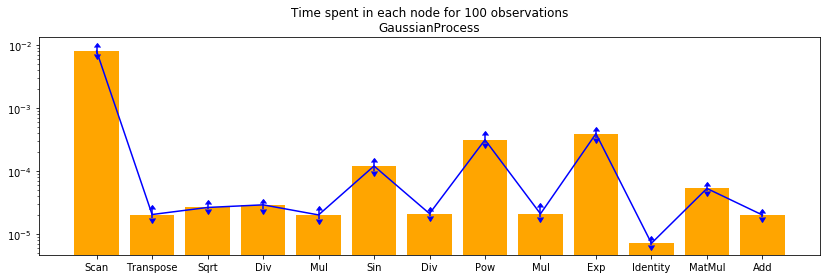

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.bar(df100.i, df100.time, align='center', color='orange')
ax.set_xticks(df100.i)
ax.set_yscale('log')
ax.set_xticklabels(df.op_type)
ax.errorbar(df100.i, df100.time, 
            numpy.abs(df100[["min_time", "max_time"]].T.values - df100.time.values.ravel()),
            uplims=True, lolims=True, color='blue')
ax.set_title("Time spent in each node for 100 observations\nGaussianProcess");

In [39]:
df100c = df100.cumsum()

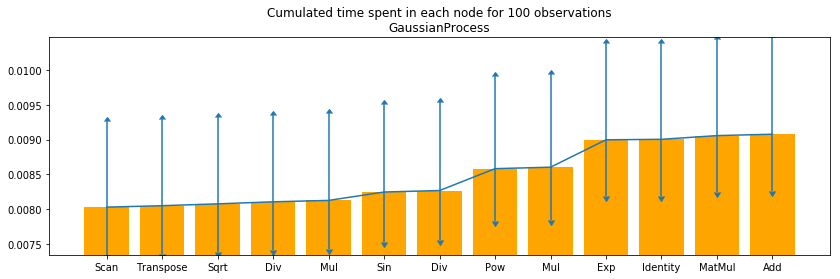

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.bar(df100.i, df100c.time, align='center', color='orange')
ax.set_xticks(df100.i)
#ax.set_yscale('log')
ax.set_ylim([df100c.min_time.min(), df100c.max_time.max()])
ax.set_xticklabels(df.op_type)
ax.errorbar(df100.i, df100c.time, 
            numpy.abs((df100c[["min_time", "max_time"]].T.values - df100c.time.values.ravel())),
            uplims=True, lolims=True)
ax.set_title("Cumulated time spent in each node for 100 observations\nGaussianProcess");

## onnxruntime2 / onnxruntime1

The runtime ``onnxruntime1`` uses *onnxruntime* for the whole ONNX graph. There is no way to get the computation time for each node except if we create a ONNX graph for each intermediate node.

In [41]:
oinfort1 = OnnxInference(onx, runtime='onnxruntime1')

In [42]:
split = oinfort1.build_intermediate()
split

OrderedDict([('scan0_2159066215928', OnnxInference(...)),
             ('scan1_2159066215928', OnnxInference(...)),
             ('kgpd_O09', OnnxInference(...)),
             ('kgpd_O08', OnnxInference(...)),
             ('kgpd_O07', OnnxInference(...)),
             ('kgpd_O06', OnnxInference(...)),
             ('kgpd_O05', OnnxInference(...)),
             ('kgpd_O04', OnnxInference(...)),
             ('kgpd_O03', OnnxInference(...)),
             ('kgpd_O02', OnnxInference(...)),
             ('kgpd_O01', OnnxInference(...)),
             ('kgpd_O0', OnnxInference(...)),
             ('gpr_O0', OnnxInference(...)),
             ('GPmean', OnnxInference(...))])

In [43]:
dfs = []
for k, v in split.items():
    print("node", k)
    res = benchmark_fct(lambda x: v.run({'X': x}), X_test)
    df = pandas.DataFrame(res)
    df['name'] = k
    dfs.append(df.reset_index(drop=False))

node scan0_2159066215928
node scan1_2159066215928
node kgpd_O09
node kgpd_O08
node kgpd_O07
node kgpd_O06
node kgpd_O05
node kgpd_O04
node kgpd_O03
node kgpd_O02
node kgpd_O01
node kgpd_O0
node gpr_O0
node GPmean


In [44]:
df = pandas.concat(dfs)
df.head()

,index,1,10,100,1000,10000,100000,name
0,average,0.001433,0.001257,0.001585,0.009513,0.042747,0.866285,scan0_2159066215928
1,deviation,0.000490,0.000179,0.000324,0.001902,0.003301,0.000000,scan0_2159066215928
2,min_exec,0.001039,0.000992,0.001324,0.007828,0.038953,0.866285,scan0_2159066215928
3,max_exec,0.003218,0.001557,0.002218,0.013174,0.046999,0.866285,scan0_2159066215928
4,repeat,20.000000,20.000000,5.000000,5.000000,3.000000,1.000000,scan0_2159066215928


In [45]:
df100c = df[df['index'] == "average"]
df100c_min = df[df['index'] == "min_exec"]
df100c_max = df[df['index'] == "max_exec"]
ave = df100c.iloc[:, 4]
ave_min = df100c_min.iloc[:, 4]
ave_max = df100c_max.iloc[:, 4]
ave.shape, ave_min.shape, ave_max.shape
index = numpy.arange(ave.shape[0])

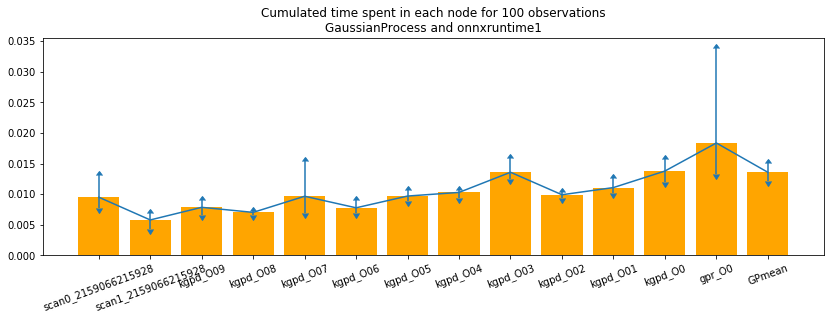

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.bar(index, ave, align='center', color='orange')
ax.set_xticks(index)
ax.set_xticklabels(df100c.name)
for tick in ax.get_xticklabels():
    tick.set_rotation(20)
ax.errorbar(index, ave, 
            numpy.abs((numpy.vstack([ave_min.values, ave_max.values]) - ave.values.ravel())),
            uplims=True, lolims=True)
ax.set_title("Cumulated time spent in each node for 100 observations\nGaussianProcess and onnxruntime1");

The visual graph helps matching the output names with the operator type. The curve is not monotononic because each experiment computes every output from the start. The number of repetitions should be increased. Documentation of function [benchmark_fct](http://www.xavierdupre.fr/app/mlprodict/helpsphinx/mlprodict/onnxrt/validate/validate.html?highlight=benchmark_fct#mlprodict.onnxrt.validate.validate.benchmark_fct) tells how to do it.